# Wasserstein GAN for Image Generation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EmoryMLIP/DeepGenerativeModelingIntro/blob/main/examples/WGAN.ipynb)

## Some References

- Original paper on by [Arjovsky et al. (2017)](https://arxiv.org/abs/1701.07875)
- Section 5.2 of our paper  [Introduction to Deep Generative Modeling](https://arxiv.org/abs/2103.05180)

## Short Mathematical Description

In training we approximately solve the saddle point problem

\begin{equation}
\newcommand{\E}{\mathbb{E}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\bftheta}{\boldsymbol{\theta}}
\newcommand{\bfphi}{\boldsymbol{\phi}}
\newcommand{\calX}{\mathcal{X}}
\newcommand{\calZ}{\mathcal{Z}}
\newcommand{\bfx}{\mathbf{x}}
\newcommand{\bfz}{\mathbf{z}}
\newcommand{\bfy}{\mathbf{y}}
\min_{\bftheta} \max_{\bfphi} \E_{\bfz \sim \calZ}\left[f_{\phi}\left(g_{\bftheta}(\bfz)\right)\right] - \E_{\bfx \sim \calX}\left[f_{\phi}(\bfx)\right] \quad \text{ subject to } \quad  f_{\bfphi} \in {\rm Lip}(f)\leq 1
\end{equation}

where

- $g_{\bftheta} : \R^2 \to \R^{784}$ is the generator (here a convolutional neural network)
- $f_{\phi} : \R^{784} \to \R^2$ is the discriminator (here a convolutional neural network)


In [48]:
# install requirements  (Colab only)
import sys,os
if 'google.colab' in sys.modules:
    dgm_dir = '/content/DeepGenerativeModelingIntro/'
    if not os.path.exists(dgm_dir):
        !git clone git://github.com/EmoryMLIP/DeepGenerativeModelingIntro.git

    sys.path.append(os.path.dirname(dgm_dir))#%%

In [49]:
import torch.nn.functional as F
import torch.nn as nn
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from os import path


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'image.interpolation' : None})
# plt.rcParams['figure.figsize'] = [10, 6]
# plt.rcParams['figure.dpi'] = 200

## Prepare Image Data

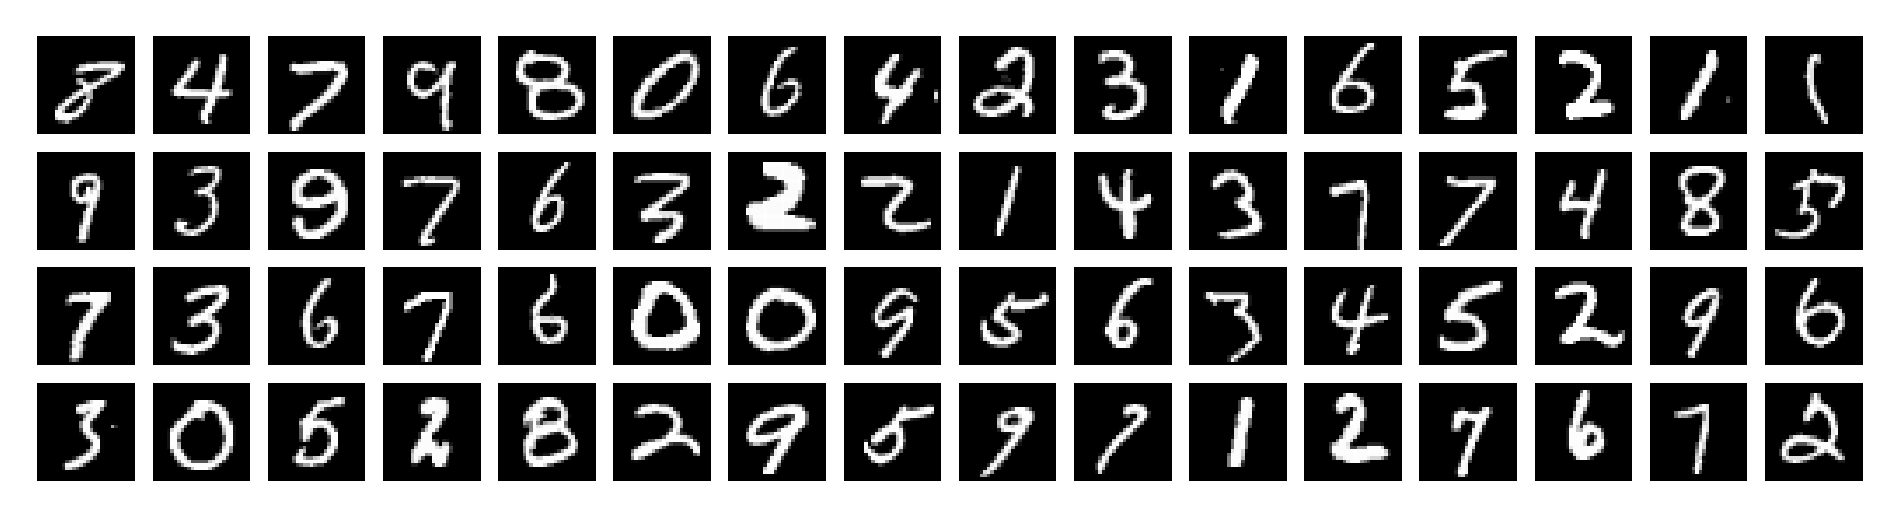

In [50]:
batch_size = 64

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


x,_ = next(iter(train_dataloader))
plt.Figure()
plt.imshow(torchvision.utils.make_grid(x,16,padding=5,pad_value=1.0).permute((1,2,0)),cmap='gray')
plt.axis("off")
plt.margins(0, 0)
plt.show()

## Select GAN Architecture

In [51]:
class Generator(nn.Module):
    def __init__(self,w,q):
        """
        :param w: number of channels on the finest level
        :param q: latent space dimension
        """
        super(Generator, self).__init__()
        self.w = w
        self.fc = nn.Linear(q, w * 2 * 7 * 7)
        self.conv2 = nn.ConvTranspose2d(w * 2, w, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(w, 1, kernel_size=4, stride=2, padding=1)

        self.bn1 = nn.BatchNorm2d(w)
        self.bn2 = nn.BatchNorm2d(2*w)

    def forward(self, z):
        """
        :param z: latent space sample
        :return: g(z)
        """
        gz = self.fc(z)
        gz = gz.view(gz.size(0), self.w * 2, 7, 7)
        gz = self.bn2(gz)
        gz = F.relu(gz)
        gz = self.conv2(gz)
        gz = self.bn1(gz)

        gz = F.relu(gz)
        gz = torch.sigmoid(self.conv1(gz))
        return gz

class Discriminator(nn.Module):
    def __init__(self, w,useSigmoid=True):
        """
        Discriminator for GANs
        :param w: number of channels on finest level
        :param useSigmoid: true --> DCGAN, false --> WGAN
        """
        super(Discriminator, self).__init__()
        self.w = w
        self.useSigmoid = useSigmoid
        self.conv1 = nn.Conv2d(1, w, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(w, w * 2, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Linear(w * 2 * 7 * 7, 1)
        self.bn1 = nn.BatchNorm2d(w)
        self.bn2 = nn.BatchNorm2d(2*w)

    def forward(self,x):
        """
        :param x: MNIST image or generated image
        :return: d(x), value of discriminator
        """
        x = (x-0.5)/0.5 #
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x,0.2)
        x = self.conv2(x)
        x = self.bn2(x)

        x = F.leaky_relu(x,0.2)
        x = x.view(x.shape[0],-1)
        x = self.fc(x)
        if self.useSigmoid:
            x = torch.sigmoid(x)
        return x

q = 2 # latent space dimension
width_disc = 32 # width of discriminator
width_dec = 32 # width of decoder

g = Generator(width_dec,q).to(device)
d = Discriminator(width_disc,useSigmoid=True).to(device)

## Train the Generator and Discriminator

We alternate between RMSprop steps of the generator and the discriminator but here it is often suggested
to use more than one step for the discriminator.

In [52]:
optimizer_g = torch.optim.RMSprop(g.parameters(), lr=0.00005)
optimizer_d = torch.optim.RMSprop(d.parameters(), lr=0.00005)
his = np.zeros((0,3))

num_steps = 10000 # number of training steps
plot_interval = 1000  # plot solution every so many steps

init_g = "./results/VAEmnist-q-2-batch_size-%d-w_enc-%d-w_dec-%d-g.pt" % (batch_size,width_disc,width_dec) # path to .pt file that contains weights of a trained generator
out_file = "./results/WGANmnist-q-2-batch_size-%d-w_disc-%d-w_dec-%d" % (batch_size,width_disc,width_dec)
  # base filename saving trained model (extension .pt), history (extension .mat), and intermediate plots (extension .png)
iter_disc = 1 # no. of iterations for training the discriminator
clip_limit = 1e-2 # limit for weights of discriminator
retrain = False

if init_g is not None and path.exists(init_g):
    print("initialize g with weights in %s" % init_g)
    g.load_state_dict(torch.load(init_g ,map_location=torch.device(device)))

if retrain == False and path.exists(out_file + "-g.pt") and path.exists(out_file + "-d.pt") and path.exists(out_file + ".mat"):
    g.load_state_dict(torch.load("%s-g.pt" % (out_file),map_location=torch.device(device)))
    d.load_state_dict(torch.load("%s-d.pt" % (out_file),map_location=torch.device(device)))
    from scipy.io import loadmat
    his_file = loadmat("%s.mat" % (out_file))
    his = his_file['his']
    print("loaded results from %s" % out_file)

else:
    print((3*"--" + "device=%s, q=%d, batch_size=%d, num_steps=%d, w_disc=%d, w_dec=%d" + 3*"--") % (device, q, batch_size, num_steps, width_disc, width_dec))
    if out_file is not None:
        import os
        out_dir, fname = os.path.split(out_file)
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        print((3*"--" + "out_file: %s" + 3*"--") % (out_file))

    print((4*"%7s    ") % ("step","J_GAN","J_Gen","ProbDist"))



    from epsTest import epsTest

    train_JGAN = 0.0
    train_JGen = 0.0
    train_epsTest = 0.0
    num_ex = 0

    def inf_train_gen():
        while True:
            for images, targets in enumerate(train_dataloader):
                yield images,targets

    get_true_images = inf_train_gen()


    for step in range(num_steps):
        g.train()
        d.train()
        # update discriminator using ascent on J_GAN =  E_x [d(x)] - E_z[d(g(z))]
        for iter_critic in range(iter_disc):
            x = get_true_images.__next__()[1][0]
            x = x.to(device)

            for p in d.parameters():
                p.data.clamp_(-0.01, 0.01)

            dx = d(x)
            z = torch.randn((x.shape[0],q),device=device)
            gz = g(z)
            dgz = d(gz)
            J_GAN = -(torch.mean(dx) - torch.mean(dgz))
            optimizer_d.zero_grad()
            J_GAN.backward()
            optimizer_d.step()
            train_JGAN -= J_GAN.item() * x.shape[0]

        # update the generator using descent on J_Gen = - E_z[d(g(z))]
        optimizer_g.zero_grad()
        z = torch.randn((x.shape[0], q), device=device)
        gz = g(z)
        dgz = d(gz)
        J_Gen = -torch.mean(dgz)
        J_Gen.backward()
        optimizer_g.step()

        # update history
        train_JGen += J_Gen.item()*x.shape[0]
        train_epsTest += epsTest(gz.detach(),x)

        num_ex += x.shape[0]

        if (step+1) % plot_interval==0:
            train_JGAN /= iter_disc * num_ex
            train_JGen /= num_ex

            print(("%06d   " + 3 * "%1.4e  ") %
                  (step + 1, train_JGAN, train_JGen, train_epsTest))
            his = np.vstack([his, [train_JGAN, train_JGen, train_epsTest]])

            plt.Figure()
            img = gz.detach().cpu()
            img -= torch.min(img)
            img /= torch.max(img)
            plt.imshow(torchvision.utils.make_grid(img, 8, 5).permute((1, 2, 0)))
            plt.title("trainWGANmnist: step=%d" % (step+1))
            if out_file is not None:
                plt.savefig(("%s-step-%d.png") % (out_file,step+1))
            plt.show()

            train_JGAN = 0.0
            train_JGen = 0.0
            train_epsTest = 0.0

            num_ex = 0

    if out_file is not None:
        torch.save(g.state_dict(), ("%s-g.pt") % (out_file))
        torch.save(d.state_dict(), ("%s-d.pt") % (out_file))

        from scipy.io import savemat
        savemat(("%s.mat") % (out_file), {"his":his})

initialize g with weights in ./results/VAEmnist-q-2-batch_size-64-w_enc-32-w_dec-32-g.pt
loaded results from ./results/WGANmnist-q-2-batch_size-64-w_disc-32-w_dec-32


## Convergence

We plot the GAN loss and the loss of the generator on the left.
Since we are solving a saddle point problem this plot can be difficult to read.
Therefore, we also plot the results of an $\epsilon$ test for equal distribution as an alternative way to meausre the quality of the generator (see [Szekely and Rizzo (2004)](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.226.377))

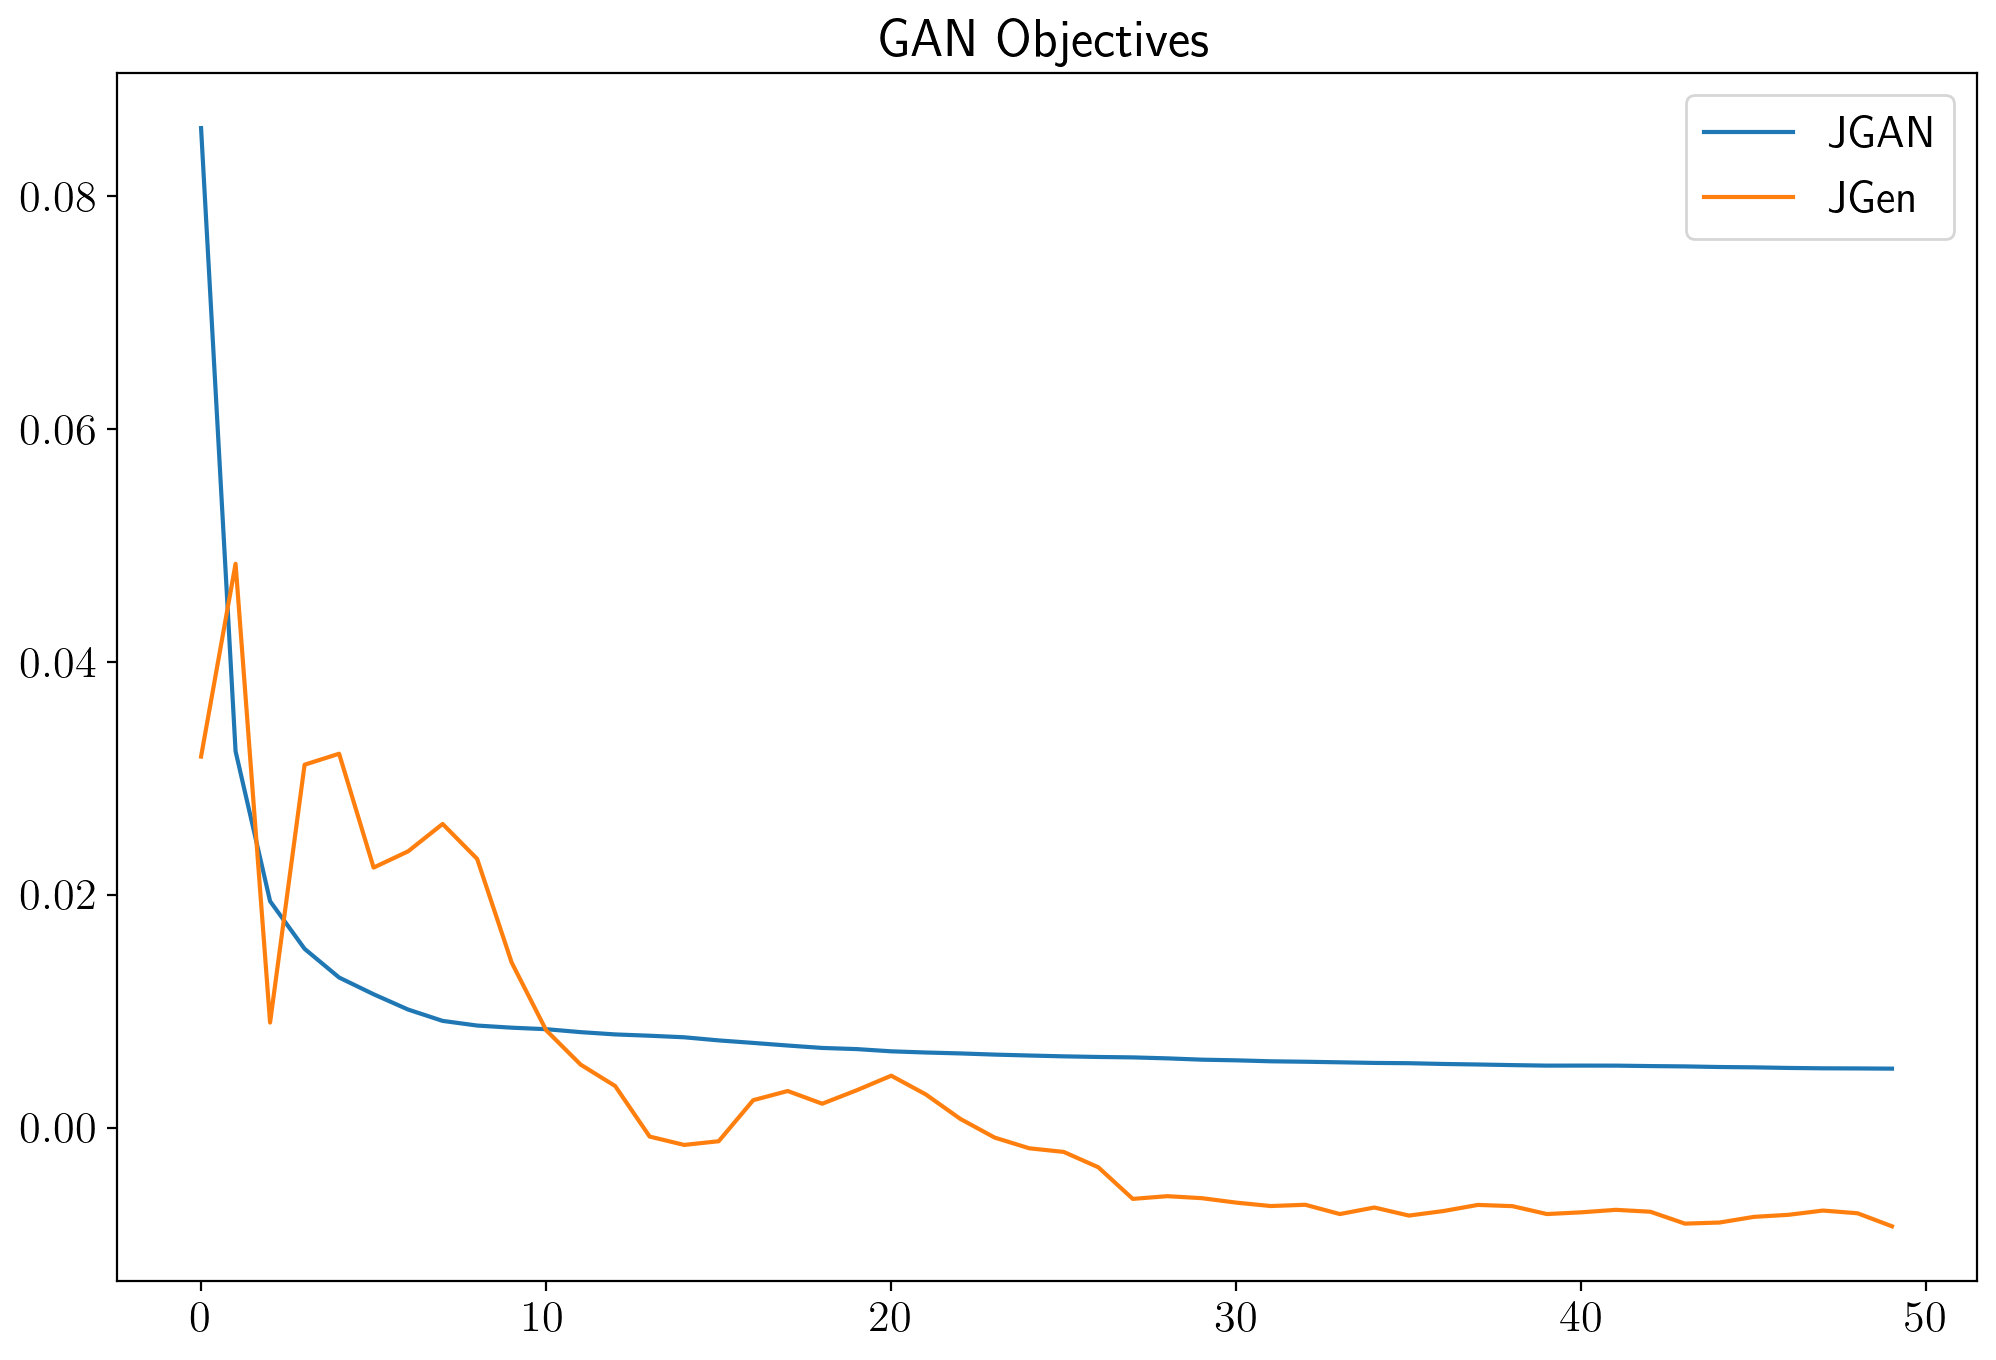

In [53]:
plt.Figure()
plt.subplot(1,2,1)
plt.plot(his[:,0:2])
plt.legend(("JGAN","JGen"))
plt.title("GAN Objectives")

plt.subplot(1,2,2)
plt.plot(his[:,2])
plt.title("eps test")



## Show Samples

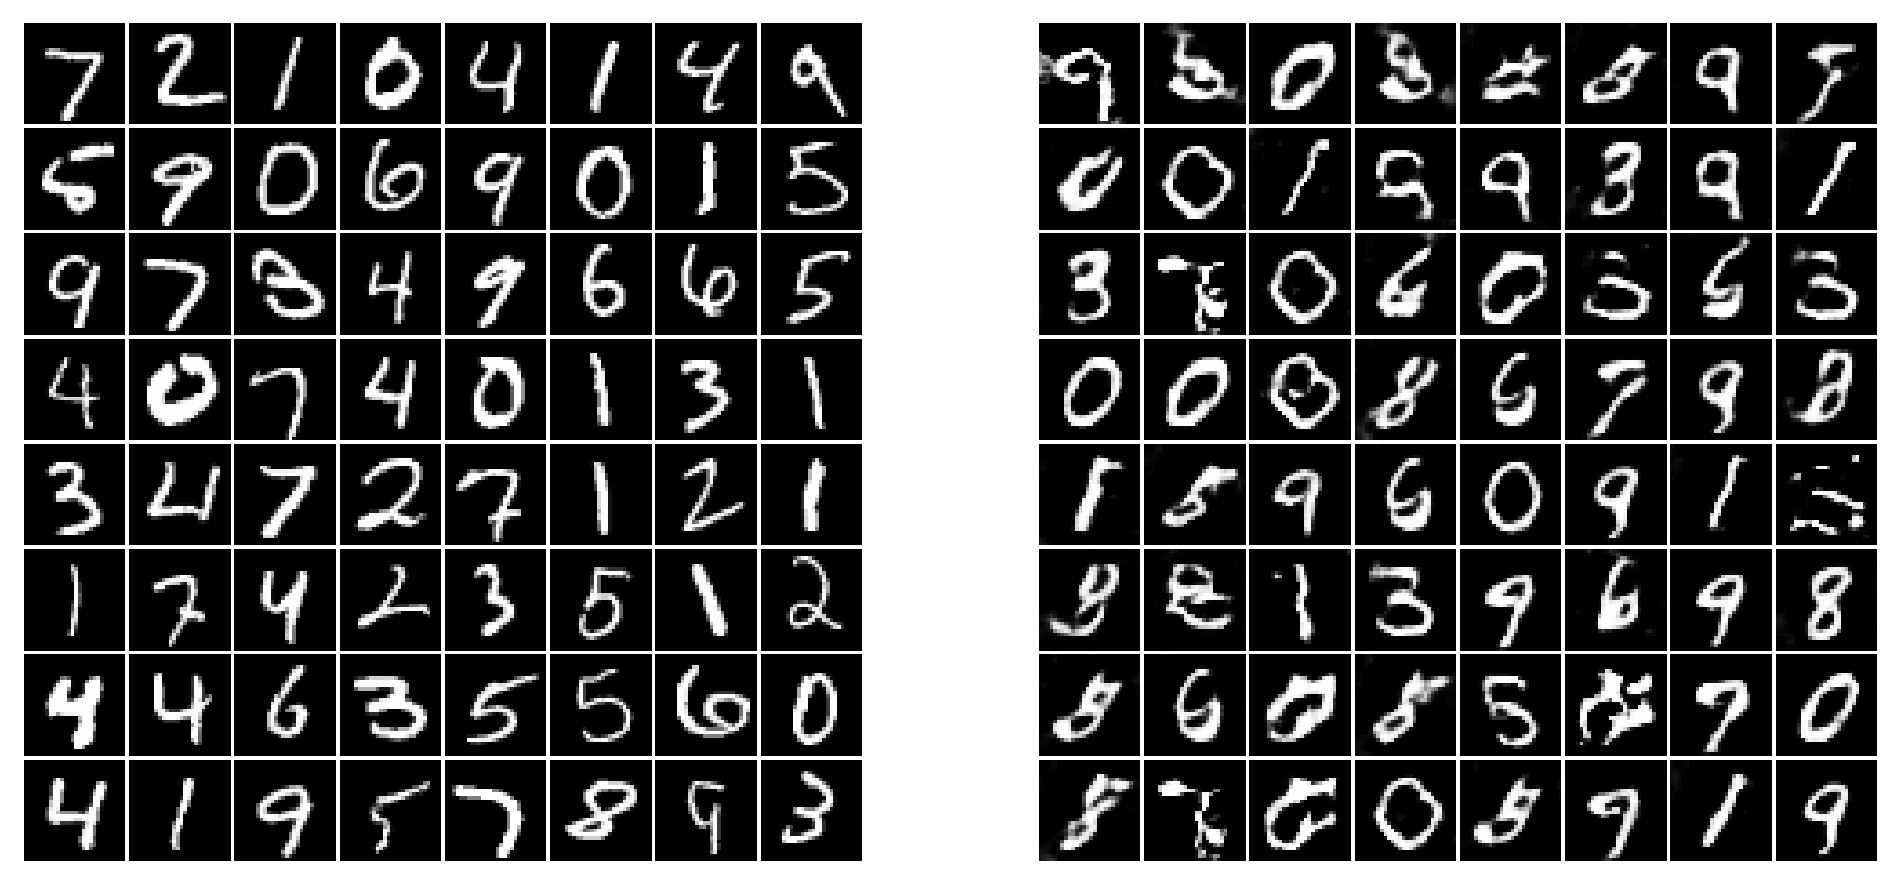

In [56]:
ncol = 8
x, _ = next(iter(test_dataloader))
plt.Figure()
plt.subplot(1,2,1)
plt.imshow(torchvision.utils.make_grid(x,ncol,1,pad_value=1).permute((1,2,0)),cmap='gray')
plt.axis("off")
plt.margins(0, 0)
plt.title("original images")

z = torch.randn((64,q),device=device)
gz = g(z)
plt.subplot(1,2,2)
plt.imshow(torchvision.utils.make_grid(gz.cpu().detach(),ncol,1,pad_value=1).permute((1,2,0)),cmap='gray')
plt.axis("off")
plt.margins(0, 0)
plt.title("generated images")
plt.show()

## Interpolate in Latent Space

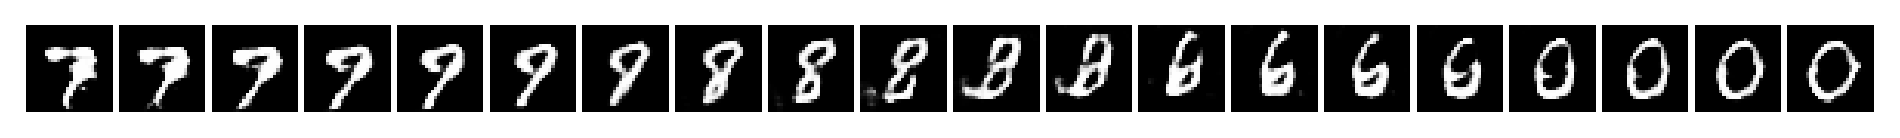

In [57]:
z1 = -torch.ones(1,2,device=device)
z2 = torch.ones(1,2,device=device)
with torch.no_grad():

    lam = torch.linspace(0,1,20,device=device).reshape(-1,1)
    zinter = z1*(1-lam) + z2*lam

    gz = g(zinter)

plt.Figure()
plt.imshow(torchvision.utils.make_grid(gz.cpu(),len(lam),2,pad_value=1).permute((1,2,0)),cmap='gray')
plt.axis("off")
plt.margins(0, 0)
plt.show()